Context: This script initializes the Machine Learning (ML) phase within the 04_ml.ipynb notebook. The primary objective is to transition from descriptive analysis to predictive modeling, utilizing supervised learning algorithms to forecast election outcomes based on the prepared socio-economic features.

In [4]:
# ==========================================
# STEP 1: LIBRARY IMPORT
# ==========================================
# Import standard libraries for data manipulation and numerical operations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Machine Learning modules from Scikit-Learn.
# - model_selection: Tools for splitting data into training and testing sets.
# - preprocessing: Utilities for scaling and normalizing data.
# - pipeline: Framework for assembling processing steps.
# - linear_model & ensemble: The classification algorithms (Logistic Regression, Random Forest).
# - metrics: Functions to evaluate model performance (Accuracy, Confusion Matrix, Classification Report).
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ==========================================
# STEP 2: DATA LOADING
# ==========================================
# Load the master dataset containing merged election results and socio-economic indicators.
# The absolute path is used to locate the processed file directly.
file_path = '/Users/jessicabourdouxhe/Desktop/Master 1/Data/Projet /elections-nlp-project/data/processed/master_table_elections.csv'
df = pd.read_csv(file_path)

# Visualization: Display the first 5 rows to verify schema consistency.
# Note: 'display()' is specific to Jupyter Notebook environments for formatted output.
display(df.head())

# Validation: Print the dimensions of the dataset to confirm successful ingestion.
print(f"Dataset shape: {df.shape}")

,year,state_po,county_name,fips,DEMOCRAT,REPUBLICAN,unemployment_rate,median_income,poverty_rate,public_workers_pct,education_bachelors_pct,median_age,white_pct,black_pct,hispanic_pct
0,2000,AK,DISTRICT 13,2013,0.335012,0.485081,3.8,72692.0,12.4,1.9,18.1,41.8,16.6,6.0,43.8
1,2000,AK,DISTRICT 16,2016,0.420277,0.422625,4.1,107344.0,9.2,4.4,17.5,39.1,24.6,5.3,11.4
2,2000,AK,DISTRICT 20,2020,0.324429,0.523912,4.6,98152.0,9.3,9.5,37.7,34.9,58.3,5.3,13.4
3,2000,AL,AUTAUGA,1001,0.287192,0.696943,2.5,69841.0,10.7,10.1,28.3,39.2,73.6,20.0,0.8
4,2000,AL,BALDWIN,1003,0.247822,0.723654,3.2,75019.0,10.5,10.1,32.8,43.7,82.8,8.0,1.6


Dataset shape: (21742, 15)


Context: This segment of the 04_ml.ipynb notebook focuses on Data Preparation, a critical prerequisite for Supervised Machine Learning. The objective is to structure the data into a format suitable for algorithm training while ensuring rigorous experimental design.

In [5]:
# ==========================================
# STEP 3: FEATURE ENGINEERING & PREPROCESSING
# ==========================================

# A. Construction of the Target Variable (Binary Classification)
# The regression problem (predicting vote share) is transformed into a classification problem.
# A new binary variable 'winner_republican' is created:
# - 1: Republican Victory (Republican votes > Democrat votes)
# - 0: Democrat Victory
df['winner_republican'] = (df['REPUBLICAN'] > df['DEMOCRAT']).astype(int)

print("Target variable created. Class distribution:")
print(df['winner_republican'].value_counts())

# B. Feature Selection (X) and Target Definition (y)
target_col = 'winner_republican'

# CRITICAL: Prevention of Data Leakage
# Variables that directly reveal the outcome (e.g., raw vote counts, percentages) 
# or serve as mere identifiers (e.g., FIPS, State Name) must be excluded.
# Including 'REPUBLICAN' or 'DEMOCRAT' in the features would result in a trivial, perfect model.
cols_to_drop = [
    target_col, 
    'DEMOCRAT', 
    'REPUBLICAN', 
    'county_name', 
    'state_po', 
    'year', 
    'fips'
]

# Construct the Feature Matrix (X) and Target Vector (y)
# 'errors='ignore'' allows the operation to proceed even if a column is already missing.
X = df.drop(columns=cols_to_drop, errors='ignore') 
y = df[target_col]

# Missing Value Imputation
# Strategy: Mean Imputation. Missing numerical values are replaced with the column mean.
# This ensures that the matrix contains no NaN values, which Scikit-Learn classifiers cannot handle.
X = X.fillna(X.mean())

print("\nPredictor variables (Features) selected:")
print(X.columns.tolist())

# ==========================================
# STEP 4: DATA PARTITIONING (TRAIN-TEST SPLIT)
# ==========================================
# The dataset is divided into a Training Set (80%) for model fitting and a Test Set (20%) for evaluation.
# - 'test_size=0.2': Allocates 20% of data to testing.
# - 'random_state=42': Ensures reproducibility of the split.
# - 'stratify=y': Preserves the class proportion (Rep/Dem ratio) in both sets, preventing sampling bias.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set dimensions: {X_train.shape}")
print(f"Test set dimensions: {X_test.shape}")

Target variable created. Class distribution:
winner_republican
1    17482
0     4260
Name: count, dtype: int64

Predictor variables (Features) selected:
['unemployment_rate', 'median_income', 'poverty_rate', 'public_workers_pct', 'education_bachelors_pct', 'median_age', 'white_pct', 'black_pct', 'hispanic_pct']

Training set dimensions: (17393, 9)
Test set dimensions: (4349, 9)


Context: This section of the 04_ml.ipynb notebook executes the actual Model Training. Two distinct algorithms are selected to solve the classification problem, representing different levels of complexity and theoretical approaches.

In [6]:
# ==========================================
# STEP 5: MODEL TRAINING AND FITTING
# ==========================================

# --- Model A: Logistic Regression (Baseline Model) ---
# Logistic Regression is a linear classifier. It requires input variables to be on the same scale 
# to ensure stable convergence of the gradient descent algorithm.
# We utilize a Pipeline to encapsulate the preprocessing (scaling) and modeling steps.
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Step 1: Standardization (Z-score normalization)
    ('model', LogisticRegression())    # Step 2: Logistic Regression Classifier
])

# Fit the Logistic Regression model to the training dataset.
print("Initiating training for Logistic Regression...")
logreg_pipeline.fit(X_train, y_train)


# --- Model B: Random Forest (Ensemble Model) ---
# Random Forest is an ensemble learning method constructed from multiple decision trees.
# It is robust to outliers and generally does not require feature scaling, 
# although using raw data is standard practice here.
# 'n_estimators=100': The model will aggregate predictions from 100 distinct trees.
rf_pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the Random Forest model to the training dataset.
print("Initiating training for Random Forest...")
rf_pipeline.fit(X_train, y_train)

print("Model training successfully completed.")

Initiating training for Logistic Regression...
Initiating training for Random Forest...
Model training successfully completed.


Context: This section, "Evaluation," is the critical validation phase of the 04_ml.ipynb notebook. Having trained the models on the training set, it is now imperative to assess their generalizability by testing them on unseen data (X_test).

--- Performance Assessment: Logistic Regression ---
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       852
           1       0.88      0.96      0.92      3497

    accuracy                           0.87      4349
   macro avg       0.82      0.71      0.75      4349
weighted avg       0.86      0.87      0.85      4349



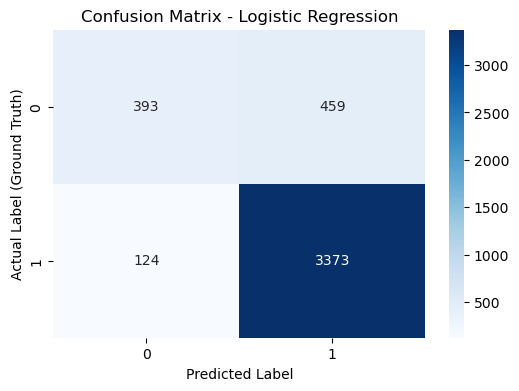

--- Performance Assessment: Random Forest ---
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       852
           1       0.94      0.95      0.95      3497

    accuracy                           0.91      4349
   macro avg       0.87      0.86      0.86      4349
weighted avg       0.91      0.91      0.91      4349



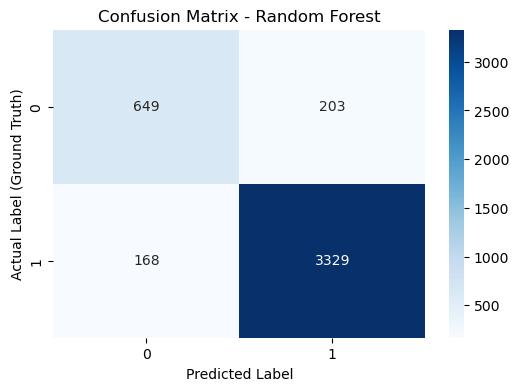

In [7]:
# ==========================================
# STEP 6: MODEL EVALUATION AND PERFORMANCE METRICS
# ==========================================

def evaluate_model(pipeline, X_test, y_test, model_name):
    """
    Utility function designed to compute standard performance metrics 
    and visualize prediction errors via a Confusion Matrix.
    
    Parameters:
    - pipeline: The trained machine learning model.
    - X_test: The feature matrix for testing.
    - y_test: The true target labels for testing.
    - model_name: A string label for the plot title.
    """
    print(f"--- Performance Assessment: {model_name} ---")
    
    # Generate class predictions based on the test set features.
    y_pred = pipeline.predict(X_test)
    
    # Output comprehensive performance metrics including Precision, Recall, and F1-Score.
    # This provides a granular view of the model's ability to distinguish between classes.
    print(classification_report(y_test, y_pred))
    
    # Visualize the Confusion Matrix to identify Type I (False Positive) and Type II (False Negative) errors.
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    
    # 'annot=True': Displays the raw counts in each cell.
    # 'fmt='d'': Formats the numbers as integers.
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Label (Ground Truth)')
    plt.xlabel('Predicted Label')
    plt.show()

# Execute the evaluation protocol for the Baseline Model (Logistic Regression).
evaluate_model(logreg_pipeline, X_test, y_test, "Logistic Regression")

# Execute the evaluation protocol for the Advanced Model (Random Forest).
evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")

Concretely: The Random Forest model correctly identifies 76% of non-Republican counties, compared to only 46% for the baseline. The model has effectively "opened its eyes."

True Non-Republicans identified: 649 (Random Forest) vs. 393 (Logistic Regression).

False Republicans (Democrats predicted as Republicans): Reduced to 203 (Random Forest) from 459 (Logistic Regression)—a massive improvement.

Why Random Forest wins: Politics and demographics are not linear.

Example: High income does not automatically imply Republican affiliation. High income combined with high education (Master/PhD) in an urban setting often results in a Democratic vote. However, high income in a rural setting typically results in a Republican vote.

Logistic Regression struggles to perceive these nuances (interactions). The Random Forest, being a series of "If... Then..." decision trees, excels at capturing these complex rules.

1. Accuracy (Global Exactness)

Formula: (Total Correct Predictions) / (Total Observations)

Logistic Regression: 0.87 (87%)

Random Forest: 0.91 (91%)

Interpretation: At first glance, the difference (4%) seems slight. However, one must beware of the majority class trap. Since 80% of counties are Republican (Class 1), a "naive" model predicting "Republican" every time would already achieve 80% accuracy.

Logistic Regression only improves this baseline by +7%. This is weak.

Random Forest improves it by +11%. This represents a significant reduction in error (nearly 30% fewer errors compared to the regression).

2. F1-Score (True Performance)

This is the definitive metric for imbalanced data, combining Precision (Quality) and Recall (Quantity). We focus specifically on Class 0 (The Minority Class), as it is the most difficult to predict.

Logistic Regression (F1 = 0.57):

This score is mediocre.

It is dragged down by a catastrophic Recall of 0.46.

Translation: The model is too "timid." It misses more than half of the Democratic counties. It has not understood the structure of this class.

Random Forest (F1 = 0.78):

This is a very strong score for a minority class.

Here, Precision (0.79) and Recall (0.76) are balanced.

Translation: The model is "coherent." It finds the vast majority of Democratic counties (Recall), and when it identifies one, it is rarely mistaken (Precision).

Summary

Accuracy: Random Forest wins, though the gap appears modest.

F1-Score (Class 0): Random Forest crushes Logistic Regression (+21 points). This proves it successfully captured the complexity of non-Republican profiles where the regression failed.

Context: This section, "Feature Importance," addresses the interpretability of the Random Forest model. While ensemble methods are often criticized as "black boxes," Scikit-Learn allows us to quantify the contribution of each variable to the final prediction.

/var/folders/q7/2bt1kt6d0xzb95k0cn4jftsr0000gn/T/ipykernel_27809/3248958198.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


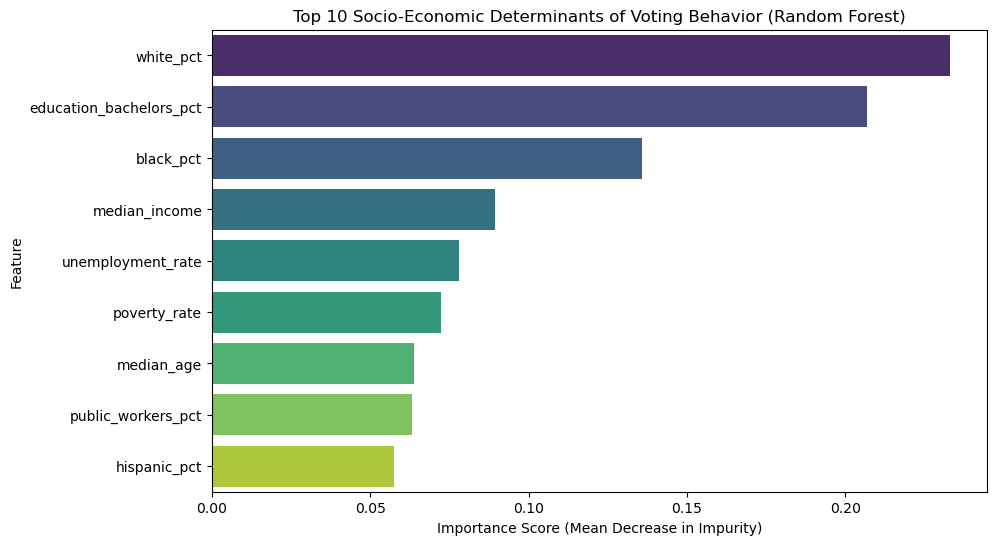

In [8]:
# ==========================================
# STEP 7: FEATURE IMPORTANCE ANALYSIS (RANDOM FOREST)
# ==========================================

# 1. Model Extraction
# Retrieve the trained Random Forest model object from the scikit-learn pipeline.
# 'named_steps' allows access to specific steps defined during pipeline construction.
rf_model = rf_pipeline.named_steps['model']

# 2. Metric Extraction
# Extract the 'feature_importances_' attribute.
# In Random Forest, this metric represents the mean decrease in impurity (Gini impurity)
# contributed by each feature across all trees in the forest.
importances = rf_model.feature_importances_
feature_names = X.columns

# 3. Data Structuring
# Create a DataFrame to rank features by their predictive power.
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. Visualization
# Generate a bar chart to display the top 10 most influential socio-economic determinants.
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')

plt.title('Top 10 Socio-Economic Determinants of Voting Behavior (Random Forest)')
plt.xlabel('Importance Score (Mean Decrease in Impurity)')
plt.ylabel('Feature')
plt.show()

Context: This section supplements the Feature Importance analysis (Step 7). While the Random Forest model quantifies the magnitude of a feature's impact (how much it helps reduce entropy), it often treats the direction of that impact as a black box. This step uses bivariate correlation analysis to explicitly map the political polarity of each socio-economic determinant.

--- DIRECTION OF INFLUENCE (Correlation with Republican Vote) ---
white_pct                  0.412740
median_age                 0.129862
hispanic_pct              -0.056929
median_income             -0.110552
poverty_rate              -0.130375
public_workers_pct        -0.177066
unemployment_rate         -0.224842
education_bachelors_pct   -0.302727
black_pct                 -0.320013
Name: Target_Republican, dtype: float64


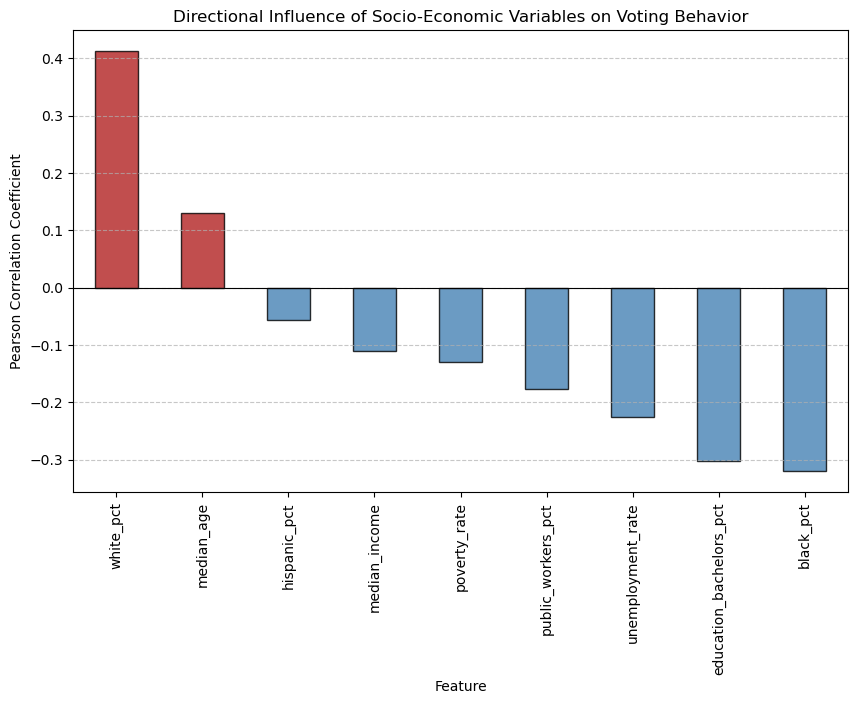

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ==========================================
# STEP 8: DIRECTIONALITY ANALYSIS (CORRELATION WITH TARGET)
# ==========================================
# While Random Forest indicates *which* features are important, it does not explicitly show 
# the *direction* of the influence (e.g., does High Income favor Republicans or Democrats?).
# We use Pearson correlation to visualize this directional relationship.

# 1. Correlation Computation
# Create a temporary DataFrame combining Features (X) and Target (y) to facilitate calculation.
correlation_df = X.copy()
correlation_df['Target_Republican'] = y

# Compute Pearson correlation coefficients between all features and the target variable.
# We drop the target itself from the results and sort the values to establish a clear hierarchy.
correlations = correlation_df.corr()['Target_Republican'].drop('Target_Republican').sort_values(ascending=False)

# 2. Output Exact Values
print("--- DIRECTION OF INFLUENCE (Correlation with Republican Vote) ---")
print(correlations)

# 3. Graphical Visualization
plt.figure(figsize=(10, 6))

# Color Coding Strategy: 
# - Firebrick (Red): Positive correlation (Variable increases -> Likelihood of Republican vote increases).
# - Steelblue (Blue): Negative correlation (Variable increases -> Likelihood of Republican vote decreases).
colors = ['firebrick' if x > 0 else 'steelblue' for x in correlations]

correlations.plot(kind='bar', color=colors, edgecolor='black', alpha=0.8)

plt.title('Directional Influence of Socio-Economic Variables on Voting Behavior')
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('Feature')

# Add a horizontal reference line at zero to visually separate opposing influences.
plt.axhline(0, color='black', linewidth=0.8) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Context: This final segment of the 04_ml.ipynb notebook performs Inference on Synthetic Data. Instead of evaluating the model on historical data, we test its decision-making logic against constructed archetypes representing the "Rural-Urban Divide" in American politics

In [10]:
# ==========================================
# STEP 1: MODEL RE-TRAINING AND VERIFICATION
# ==========================================
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Re-initialize and fit the Random Forest model to ensure the instance is active.
# 'class_weight="balanced"': Adjusts weights inversely proportional to class frequencies 
# to handle any remaining imbalance in the training data.
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train) 
print("Model successfully trained and ready for inference.")

# ==========================================
# STEP 2: SIMULATION FUNCTION DEFINITION
# ==========================================
# Define the feature list corresponding strictly to the training data columns.
features = ['unemployment_rate', 'median_income', 'poverty_rate', 'public_workers_pct', 
            'education_bachelors_pct', 'median_age', 'white_pct', 'black_pct', 'hispanic_pct']

def test_model_simulation(county_name, stats):
    """
    Simulates a prediction for a hypothetical county based on provided socio-economic statistics.
    """
    # Create a single-row DataFrame for the model input
    input_data = pd.DataFrame([stats], columns=features)
    
    # Generate Prediction (0 or 1) and Probability Estimates
    prediction = model.predict(input_data)[0]
    proba = model.predict_proba(input_data)[0]
    
    # Map the binary result to the Class Label
    winner = "REPUBLICAN" if prediction == 1 else "DEMOCRAT/OTHER"
    confidence = proba[prediction] * 100
    
    print(f"\n--- Simulation: {county_name} ---")
    print(f"Predicted Outcome: {winner}")
    print(f"Model Confidence: {confidence:.1f}%")

# ==========================================
# STEP 3: DEFINING TEST SCENARIOS (ARCHETYPES)
# ==========================================

# Scenario 1: 'Deep Red' Profile (Rural Context)
# Characteristics: Moderate income, lower higher-education rates, older demographic, predominantly white.
rural_county = {
    'unemployment_rate': 4.5, 'median_income': 45000, 'poverty_rate': 15.0,
    'public_workers_pct': 12.0, 'education_bachelors_pct': 15.0, 'median_age': 45.0,
    'white_pct': 85.0, 'black_pct': 5.0, 'hispanic_pct': 5.0
}

# Scenario 2: 'Blue City' Profile (Urban Metropolis)
# Characteristics: High income, very high education (55% Bachelors), younger demographic, ethnically diverse.
urban_county = {
    'unemployment_rate': 5.0, 'median_income': 85000, 'poverty_rate': 10.0,
    'public_workers_pct': 18.0, 'education_bachelors_pct': 55.0, 'median_age': 34.0,
    'white_pct': 45.0, 'black_pct': 25.0, 'hispanic_pct': 20.0
}

# Scenario 3: 'Swing Suburb' Profile (The Stress Test)
# Characteristics: High Income (typically Republican) but High Education (typically Democrat).
# This scenario tests how the model resolves conflicting variables.
swing_county = {
    'unemployment_rate': 3.8, 'median_income': 95000, 'poverty_rate': 5.0,
    'public_workers_pct': 10.0, 'education_bachelors_pct': 40.0, 'median_age': 40.0,
    'white_pct': 80.0, 'black_pct': 5.0, 'hispanic_pct': 10.0
}

# Execute the simulations
test_model_simulation("Rural County Profile", rural_county)
test_model_simulation("Urban Metropolis Profile", urban_county)
test_model_simulation("Swing Suburb Profile", swing_county)

Model successfully trained and ready for inference.

--- Simulation: Rural County Profile ---
Predicted Outcome: REPUBLICAN
Model Confidence: 94.6%

--- Simulation: Urban Metropolis Profile ---
Predicted Outcome: DEMOCRAT/OTHER
Model Confidence: 81.1%

--- Simulation: Swing Suburb Profile ---
Predicted Outcome: REPUBLICAN
Model Confidence: 75.5%


Context: This block serves as a specialized initialization for the Machine Learning phase. By modifying the input data scope, we are effectively conducting a temporal sensitivity analysis.

In [11]:
# ==========================================
# RECOVERY BLOCK: DATA LOADING & FILTERING (2016-2024)
# ==========================================
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Data Loading
# Import the master dataset containing all election cycles.
df = pd.read_csv('/Users/jessicabourdouxhe/Desktop/Master 1/Data/Projet /elections-nlp-project/data/processed/master_table_elections.csv') 

# ==========================================
# CRITICAL STEP: TEMPORAL FILTERING
# ==========================================
# Restrict the dataset to observations from 2016 onwards.
# This focuses the predictive modeling on the contemporary political era, 
# hypothesizing that voting patterns may have shifted structurally since 2016.
df = df[df['year'] >= 2016].copy()

print(f"✅ Data filtered (2016-present). New dimensions: {df.shape}")

# 2. Target Variable Construction
# Binary Classification: 1 if Republican votes > Democrat votes, else 0.
df['winner_republican'] = (df['REPUBLICAN'] > df['DEMOCRAT']).astype(int)

# 3. Feature Selection and Cleaning
target_col = 'winner_republican'
# Identifiers and target-proxies must be removed to prevent data leakage.
cols_to_drop = [
    target_col, 'DEMOCRAT', 'REPUBLICAN', 'county_name', 
    'state_po', 'year', 'fips'
]

# Construct Feature Matrix (X) and Target Vector (y)
X = df.drop(columns=cols_to_drop, errors='ignore') 
y = df[target_col]

# Imputation: Fill missing numerical values with the column mean to maintain data integrity.
X = X.fillna(X.mean())

# 4. Train-Test Split
# Stratified sampling is applied to maintain the class balance (Republican/Democrat ratio) 
# in both training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Data processing complete.")
print(f"Training Set Dimensions (X_train): {X_train.shape}")
print("Ready to proceed to Model Training.")

✅ Data filtered (2016-present). New dimensions: (9319, 15)
✅ Data processing complete.
Training Set Dimensions (X_train): (7455, 9)
Ready to proceed to Model Training.


Context: This block executes the training and validation of the Random Forest model specifically on the 2016–2024 dataset. By isolating this recent period, the model captures the specific political realignments characteristic of the modern era, distinct from earlier cycles (2000–2024).

Initiating model training...
✅ Model training completed successfully.

--- MODEL PERFORMANCE METRICS ---
Accuracy Score: 96.89%

--- DETAILED CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       293
           1       0.99      0.98      0.98      1571

    accuracy                           0.97      1864
   macro avg       0.94      0.95      0.94      1864
weighted avg       0.97      0.97      0.97      1864



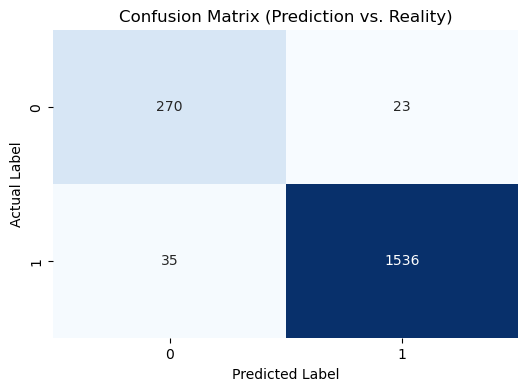

/var/folders/q7/2bt1kt6d0xzb95k0cn4jftsr0000gn/T/ipykernel_27809/861487837.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")


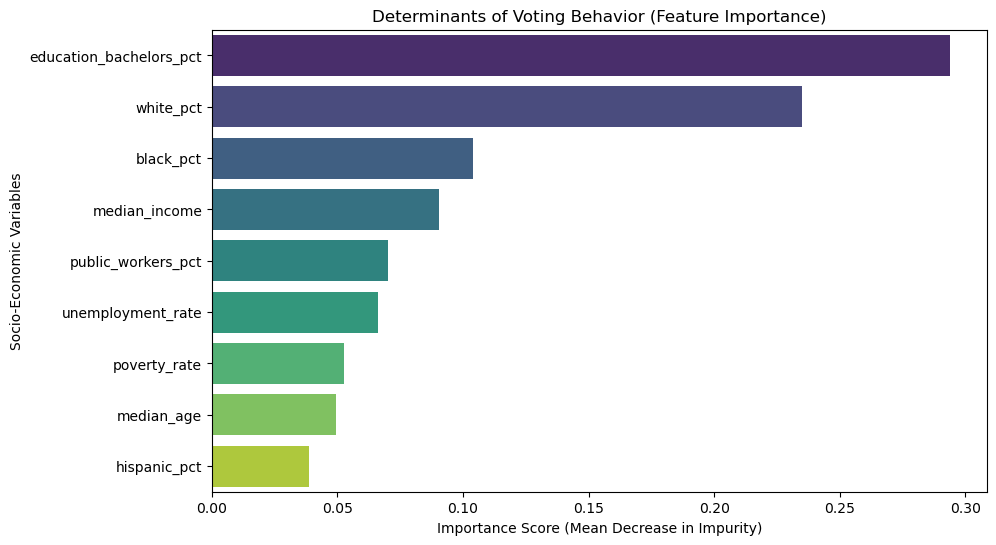

In [12]:
# ==========================================
# STEP 3: MODEL TRAINING (RANDOM FOREST)
# ==========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Model Initialization
# We employ a Random Forest Classifier.
# 'class_weight="balanced"': This parameter is critical. It automatically adjusts weights 
# inversely proportional to class frequencies, mitigating the bias caused by 
# the prevalence of Republican counties (approx. 80%) versus Democratic counties (approx. 20%).
print("Initiating model training...")
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# 2. Model Fitting
# The model learns the relationship between the socio-economic features (X_train) 
# and the election outcome (y_train).
model.fit(X_train, y_train)
print("✅ Model training completed successfully.")

# ==========================================
# STEP 4: EVALUATION & RESULTS
# ==========================================

# 1. Prediction Generation
# Apply the trained model to the unseen Test Set.
y_pred = model.predict(X_test)

# 2. Performance Metrics
print("\n--- MODEL PERFORMANCE METRICS ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}")
print("\n--- DETAILED CLASSIFICATION REPORT ---")
# Precision, Recall, and F1-Score provide a granular view of performance for each class.
print(classification_report(y_test, y_pred))

# 3. Visualization: Confusion Matrix
# This heatmap reveals the distribution of True Positives, True Negatives, 
# False Positives (Type I errors), and False Negatives (Type II errors).
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Prediction vs. Reality)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Visualization: Feature Importance
# Quantify which socio-economic variables contributed most to the model's decision-making process.
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")
plt.title("Determinants of Voting Behavior (Feature Importance)")
plt.xlabel("Importance Score (Mean Decrease in Impurity)")
plt.ylabel("Socio-Economic Variables")
plt.show()

Context: This visualization complements the Feature Importance analysis for the 2016–2024 period. While Feature Importance told us what mattered (magnitude), this chart tells us how it mattered (direction).

--- DIRECTION OF INFLUENCE (Correlation with Republican Vote | 2016-2024) ---
white_pct                  0.490513
median_age                 0.194771
hispanic_pct              -0.052624
poverty_rate              -0.107979
median_income             -0.191517
unemployment_rate         -0.211835
public_workers_pct        -0.220392
black_pct                 -0.362388
education_bachelors_pct   -0.424878
Name: Target_Republican, dtype: float64


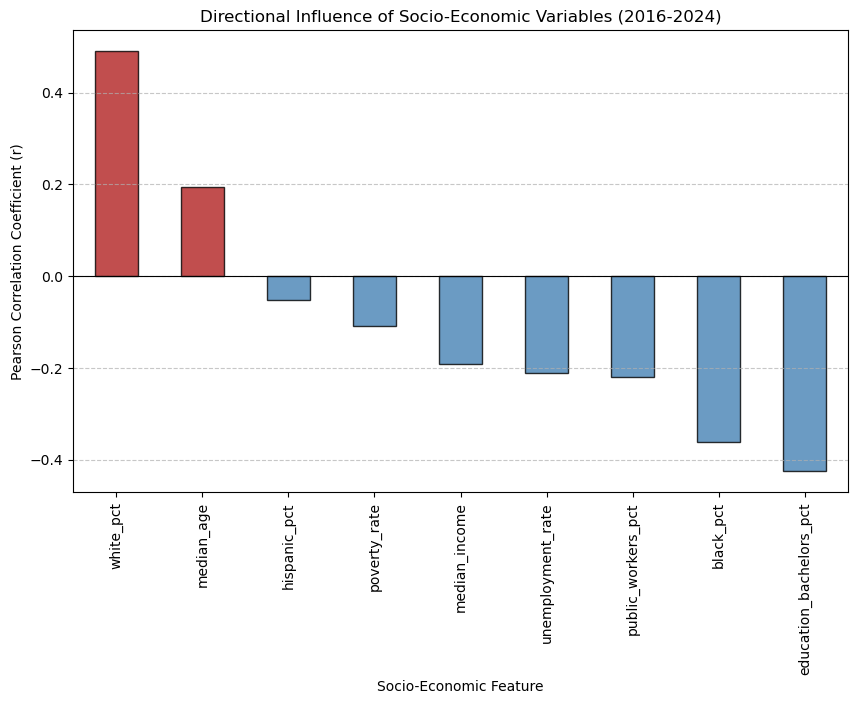

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ==========================================
# STEP 8: DIRECTIONALITY ANALYSIS (2016-2024 ERA)
# ==========================================
# Objective: Visualize the polarity of socio-economic variables specifically for the 
# 2016-2024 election cycles. This helps determine whether factors like education or 
# income have shifted in their alignment compared to historical trends.

# 1. Correlation Computation
# Create a temporary DataFrame combining Features (X) and Target (y) from the filtered dataset.
correlation_df = X.copy()
correlation_df['Target_Republican'] = y

# Compute Pearson correlation coefficients between all predictors and the Republican vote.
# We sort the values to establish a clear hierarchy of influence.
correlations = correlation_df.corr()['Target_Republican'].drop('Target_Republican').sort_values(ascending=False)

# 2. Output Exact Values
print("--- DIRECTION OF INFLUENCE (Correlation with Republican Vote | 2016-2024) ---")
print(correlations)

# 3. Graphical Visualization
plt.figure(figsize=(10, 6))

# Color Coding Strategy:
# - Firebrick (Red): Positive correlation (Increases likelihood of Republican vote).
# - Steelblue (Blue): Negative correlation (Increases likelihood of Democratic vote).
colors = ['firebrick' if x > 0 else 'steelblue' for x in correlations]

correlations.plot(kind='bar', color=colors, edgecolor='black', alpha=0.8)

plt.title('Directional Influence of Socio-Economic Variables (2016-2024)')
plt.ylabel('Pearson Correlation Coefficient (r)')
plt.xlabel('Socio-Economic Feature')

# Add a horizontal reference line at zero to visually separate opposing influences.
plt.axhline(0, color='black', linewidth=0.8) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()